In [ ]:
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Preprocessing

In [ ]:
df_syl = pd.read_csv('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/Syllable_dictionary.txt', sep=' ', header=None, names=["Word", "Syllables", "Syllables Special"])
df_sonnets = pd.read_csv('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt', sep='\r\n', header=None, names=["Line"])

<ipython-input-2-6bc81481423d>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_sonnets = pd.read_csv('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt', sep='\r\n', header=None, names=["Line"])


In [ ]:
def remove_punct(text):
  punctuations = '!"#$%&\()*+,./:;<=>?@[\\]^_`{|}~'
  for punc in punctuations:
    if punc in text:
      text = text.replace(punc, ' ')
  return text.strip()

In [ ]:
# Remove sonnet 99 and 126 since they are not 14 lines
df_sonnets = df_sonnets.drop(df_sonnets.index[1875:1888])
df_sonnets = df_sonnets.drop(df_sonnets.index[1470:1486])

In [ ]:
df_sonnets = df_sonnets.drop(df_sonnets.index[0:-1:15]) # Remove poem numbers
df_sonnets['Line'] = df_sonnets['Line'].str.lower() # Make all words lowercase
df_sonnets['Line'] = df_sonnets['Line'].apply(remove_punct) # Remove all punctuation besides hyphens and apostrophes
df_sonnets['Line']=df_sonnets['Line'].apply(lambda X: X.split()) #split into tokens

Rhyming

In [ ]:
#fix indices of df_sonnets
df_sonnets = df_sonnets.reset_index(drop=True)
#rhyming dictionary will be a list of tuples:
rhymes = []
quatrain_count = 0
i = 0
while i < len(df_sonnets.index):
    #every three quatrains, there is a couplet
    if quatrain_count == 3:
        rhymes.append((df_sonnets['Line'][i][-1], df_sonnets['Line'][i+1][-1]))
        quatrain_count = 0
        #index by only two lines
        i -= 2
    else:
        rhymes.append((df_sonnets['Line'][i][-1], df_sonnets['Line'][i+2][-1]))
        rhymes.append((df_sonnets['Line'][i+1][-1], df_sonnets['Line'][i+3][-1]))
        quatrain_count += 1
    #index by one quatrain
    i += 4


In [ ]:
#reverse lines in df_sonnet:
def reverse_line(line):
    return line[::-1]

df_sonnets_reverse = df_sonnets.copy()
df_sonnets_reverse['Line'] = df_sonnets_reverse['Line'].apply(reverse_line)

In [ ]:
# Need to represent our data numerically, so generate word_to_num and num_to_word maps
def gen_maps(lst):
  word_to_num = {}
  num_to_word = {}
  word_id = 0
  for sentence in lst:
    for word in sentence:
      if not word in word_to_num:
        word_to_num[word] = word_id
        num_to_word[word_id] = word
        word_id += 1
  return word_to_num, num_to_word

In [ ]:
# Finally, create new training data that is a numerical representation, where every unique number corresponds to a word
def convert_data(lst, map):
  all_seqs = []
  for sentence in lst:
    mapped_sentence = (pd.Series(sentence)).map(map) #convert the list to a pandas series temporarily before mapping
    all_seqs.append(list(mapped_sentence))
  return all_seqs

In [ ]:
# Generate a list of sequences, where sequences are sentences represented by [word1, word2, ..., wordn]

sentence_list = df_sonnets_reverse['Line'].values.tolist()
word_to_num, num_to_word = gen_maps(sentence_list)
training_data = convert_data(sentence_list, word_to_num)
words_data = convert_data(training_data, num_to_word)

In [ ]:
# Generate the map for words to syllables
def create_maps(lst):
  word_to_syllable = {}
  word_to_syllable_end = {}

  for ls in lst:
    [word, s1, s2] = ls

    if s1[0]=='E':
      word_to_syllable_end[word] = int(s1[1])
      word_to_syllable[word] = int(s2[0])

    elif s2[0]=='E':
      word_to_syllable_end[word] = int(s2[1])
      word_to_syllable[word] = int(s1[0])

    elif s2[0]=='X':
      word_to_syllable_end[word] = int(s1[0])
      word_to_syllable[word] = int(s1[0])

    elif s1[0]!='X' and s2[0]!='X':
      word_to_syllable_end[word] = [int(s1[0]), int(s2[0])]
      word_to_syllable[word] = [int(s1[0]), int(s2[0])]

  return word_to_syllable, word_to_syllable_end

In [ ]:
# Generate a list of sequences, where sequences are sentences represented by [word1, word2, ..., wordn]
df_syl_rem = df_syl.replace(np.nan,'X')
dict_lst = df_syl_rem.values.tolist()
word_to_syllable, word_to_syllable_end = create_maps(dict_lst)

In [ ]:
#get rhyming end words to be used in poem
end_words = random.sample(rhymes, 7)

end_words_list = []
for i in range(0,6,2):
    end_words_list.append(end_words[i][0])
    end_words_list.append(end_words[i+1][0])
    end_words_list.append(end_words[i][1])
    end_words_list.append(end_words[i+1][1])

end_words_list.append(end_words[-1][0])
end_words_list.append(end_words[-1][1])
end_words_nums = []
for word in end_words_list:
    end_words_nums.append(word_to_num[word])


#HMM Code:

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.

            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to L - 1. In other words, a list of
                        lists.

                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)

                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)

                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters, ):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]

                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]


                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M, end_word=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''
        emission = []
        state = random.choice(range(self.L))
        states = []
        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            if t == 0 and end_word:
                emission.append(end_word)
            else:
                emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)

    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.

        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

#HMM Helper Code

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=10, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)
        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1

            # Add the encoded word.
            obs_elem.append(obs_map[word])

        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06

    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)

    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)

            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


# Unsupervised Learning

In [ ]:
## Try unsupervised learning with various number of hidden states
hmm_map = {}

for i in range(2, 11):
  HMM = unsupervised_HMM(training_data, i, 50)
  hmm_map[i] = HMM


# Poem Generation

In [ ]:
def is_int(v):
    return type(v) is int

def syllable_count(x, sum, i, target):
  line = x.split(" ")
  while i < (len(line)):
    word = line[i]
    if word=="\'":
      i += 1
      continue
    if word not in ["\'gainst", "\'greeing", "\'scaped", "\'tis", "\'twixt", "th\'", "t\'"]:
      if word[len(word)-1]=="\'":
        word = word[0:(len(word)-1)]
      if word[0]=="\'":
        word = word[1:]

    num = 0
    if i == (len(line)-1):
      num = word_to_syllable_end[word]
    else:
      num = word_to_syllable[word]

    if is_int(num):
      sum += num
    else:
      if syllable_count(x, sum+num[0], i+1, target):
        True
      sum += num[1]
    i += 1
  return (sum == target)


def sequence_generator(M, the_hmm, end_words_nums):
    '''
    Generates sonets of length M using the HMM above training on
    Shakespearean sonnets
     for a given n and prints the results.
    Arguments:
        M:          Number of lines in the sonnet.
        the_hmm:   The HMM that is being used for the gernations.
    '''
    # Generate M lines for the sonnet which in our case will be 14.
    i = 0
    while i < M:
      # Initialize an HMM.
      HMM = the_hmm

      # Choose random number of words for the line
      k = random.randint(4, 8)

      # Generate a single input sequence of length k.
      emission, states = HMM.generate_emission(k, end_words_nums[i])
      emission.reverse()
      x = ' '.join([str(num_to_word[i]) for i in emission])

      if syllable_count(x, 0, 0, 10):
        print(x)
        i += 1

    print('')

for i in range(2,11):
  print("This sonnet is for an HMM with " + str(i) + " hidden states: ")
  print("-----------------------------------------------------")
  sequence_generator(14, hmm_map[i], end_words_nums)

This sonnet is for an HMM with 2 hidden states: 
-----------------------------------------------------
art the for therefore love was living face
by windows best eyes not pitiful thee
lofty and i most summer style lips grace
to blanks have only will away this me
laid and more semblance many that mine day
at stars she my and tempteth gracious state
his part was of your appetite towards stay
war decrepit i dear to steal fall gate
is converted i tongue-tied so shake now
dressings argument self beauty and take
vile unless it breath consumed kind and bow
sleep sweet tombed since poets thievish it sake
to-day beauty injury pity end
told my heart waste another falsehood that '

This sonnet is for an HMM with 3 hidden states: 
-----------------------------------------------------
with being sightless mine that removed face
thy husbandry the all eye that of thee
whether that self woes like she restored grace
enough to i heaven's eyes things a me
thou presume case are roses came his day
unless s

In [ ]:
def haikus_generator(the_hmm):
    '''
    Generates haikus which are 3 lines where the 1st is 5 syllables,
    the 2nd is 7 syllables, and the 3rd is 5 syllables.
     for a given n and prints the results.
    Arguments:
        the_hmm:      The HMM that is beign used for the generation.
    '''
    # Initialize an HMM.
    HMM = the_hmm

    # Generate the first line of the haiku

    targets = [5, 7, 5]
    for target in targets:
      i = 0
      while i < 1:
        # Choose random number of words for the line
        k = random.randint(2, 7)

        # Generate a single input sequence of length k.
        emission, states = HMM.generate_emission(k)
        x = ' '.join([str(num_to_word[i]) for i in emission])

        if syllable_count(x, 0, 0, target):
          print(x)
          i += 1

    print('')

for i in range(2,11):
  print("This haiku is for an HMM with " + str(i) + " hidden states: ")
  print("-----------------------------------------------------")
  haikus_generator(hmm_map[i])

This haiku is for an HMM with 2 hidden states: 
-----------------------------------------------------
gravity fond chide
end offence desiring men
misuse deep what the

This haiku is for an HMM with 3 hidden states: 
-----------------------------------------------------
me are the or known
me splendour hear semblance sail
another than her

This haiku is for an HMM with 4 hidden states: 
-----------------------------------------------------
cut me since most to
world doth doth know governs so
find which and renewed

This haiku is for an HMM with 5 hidden states: 
-----------------------------------------------------
churl the not beauty
abundance acquaintance whole
your thou oaths of must

This haiku is for an HMM with 6 hidden states: 
-----------------------------------------------------
which not your unless
though is it death and doth to
greet note shows maiden

This haiku is for an HMM with 7 hidden states: 
-----------------------------------------------------
hue name but happier


# Visualizations


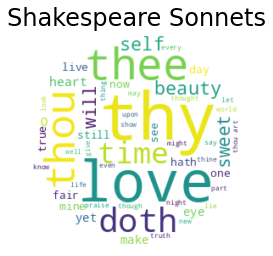

In [ ]:
text = urllib.request.urlopen('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt').read().decode('utf-8')
wordcloud = text_to_wordcloud(text, title='Shakespeare Sonnets')

In [ ]:
obs, obs_map = parse_observations(text)
sentence_list = df_sonnets_reverse['Line'].values.tolist()
word_to_num, num_to_word = gen_maps(sentence_list)
training_data = convert_data(sentence_list, word_to_num)
words_data = convert_data(training_data, num_to_word)
hmm = unsupervised_HMM(training_data, 6, 50)

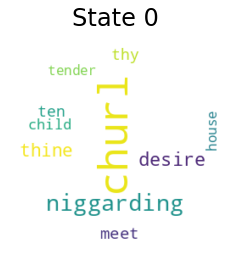

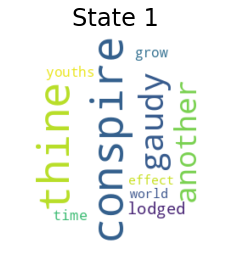

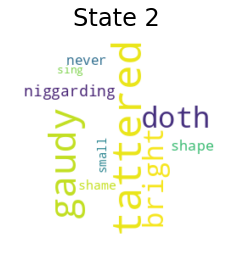

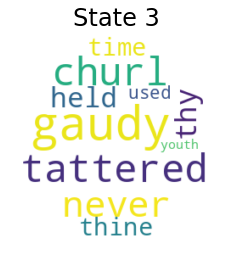

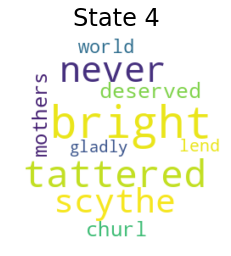

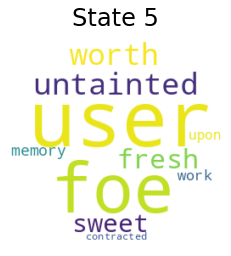

In [ ]:
wordclouds = states_to_wordclouds(hmm, obs_map, max_words=10)

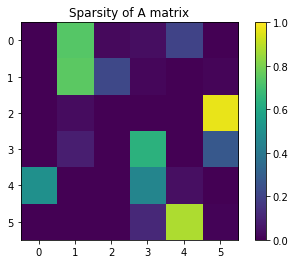

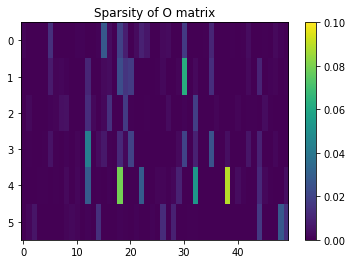

In [ ]:
visualize_sparsities(hmm, O_max_cols=50)

Sparcity Visualization for 2 hidden states


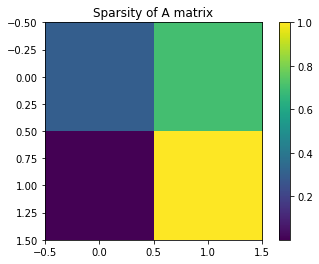

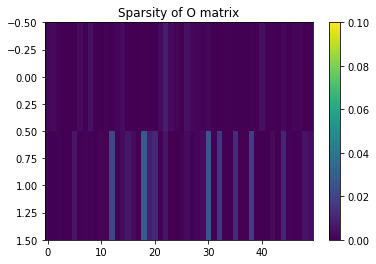

Sparcity Visualization for 3 hidden states


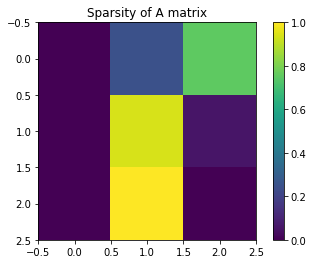

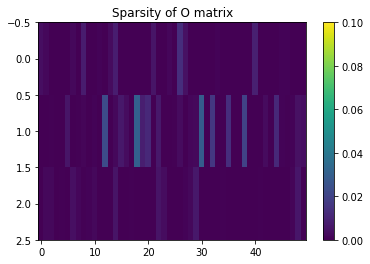

Sparcity Visualization for 4 hidden states


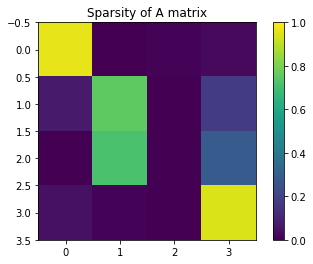

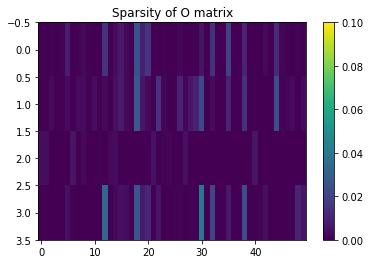

Sparcity Visualization for 5 hidden states


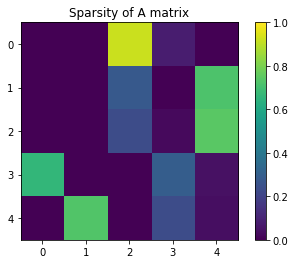

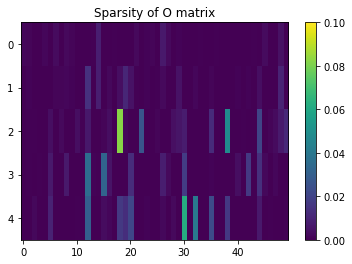

Sparcity Visualization for 6 hidden states


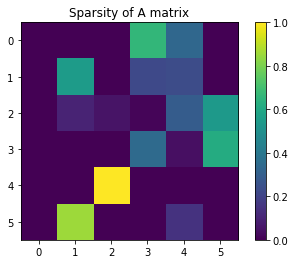

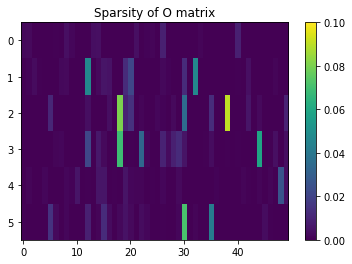

Sparcity Visualization for 7 hidden states


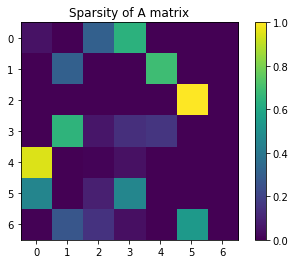

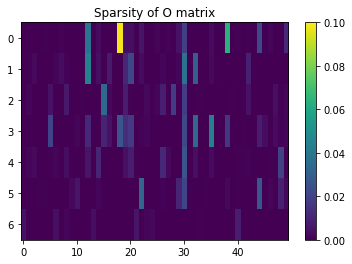

Sparcity Visualization for 8 hidden states


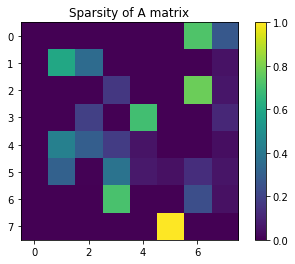

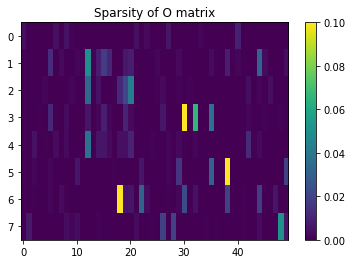

Sparcity Visualization for 9 hidden states


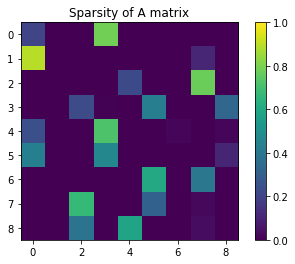

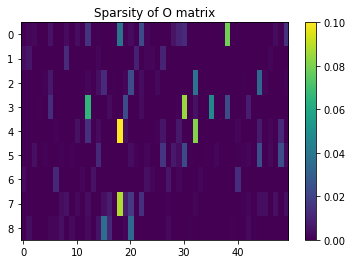

Sparcity Visualization for 10 hidden states


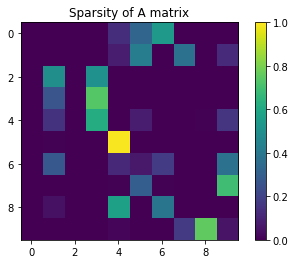

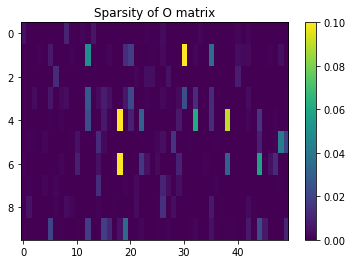

In [ ]:
for i in range(2, 11):
  HMM = hmm_map[i]
  print("Sparcity Visualization for " + str(i) + " hidden states")
  visualize_sparsities(HMM, O_max_cols=50)

In [ ]:
print(wordcloud.words_.keys())

dict_keys(['thy', 'love', 'thee', 'thou', 'doth', 'time', 'beauty', 'self', 'sweet', 'will', 'heart', 'eye', 'make', 'yet', 'O', 'now', 'day', 'fair', 'one', 'hath', 'still', 'mine', 'live', 'true', 'see', 'thought', 'look', 'give', 'thine', 'world', 'say', 'though', 'thou art', 'praise', 'upon', 'every', 'show', 'may', 'know', 'new', 'let', 'part', 'might', 'well', 'thing', 'truth', 'life', 'night', 'even', 'lie'])
